## 1. Layer S1
Implementation of layer S1 consists of loading images and applying series of transformations to convert an image into spike-wave tensor. We will load images with the help of Torchvision's `ImageFolder` dataset and PyTorch's `DataLoader`, but first, we need to prepare the image transform.

The whole pipeline of image transformation is as follows:<br> image >> grayscale image >> PyTorch's 3D tensor >> 4D tensor (time dimension) >> Gabor filters >> lateral inhibition >> intencity-to-latency encoding.

`SpykeTorch.utils` provides `Filter` class which is suitable for applying different filter kernels on a 4D input tensor. Here, we create a `Filter` object by providing a list of 4 Gabor filter kernels. We involve negative edges into our computations by setting `use_abs` to `True`.

In [87]:
import SpykeTorch.utils as utils

kernels = [	utils.GaborKernel(window_size = 3, orientation = 45+22.5),
			utils.GaborKernel(3, 90+22.5),
			utils.GaborKernel(3, 135+22.5),
			utils.GaborKernel(3, 180+22.5)]
filter = utils.Filter(kernels, use_abs = True)

To add a new dimension to the tensor, we use the `unsqueeze` method provided by PyTorch. This new extra dimension will be considered as the first dimension of the tensor.

In [88]:
def time_dim(input):
	return input.unsqueeze(0)

Grayscale and Tensor conversion are provided by Torchvision. `SpykeTorch.functional.pointwise_inhibition` implements lateral inhibition among features and `SpykeTorch.utils.Intensity2Latency` object generates the spike-wave tensor based on intensities. All in all, the whole image to spike-wave transform can be written as a composition of several transforms:

In [89]:
import SpykeTorch.utils as utils
import SpykeTorch.functional as sf
import torchvision.transforms as transforms

transform = transforms.Compose(
	[transforms.Grayscale(),
	transforms.ToTensor(),
    transforms.Resize(64),
	time_dim,
	filter,
	sf.pointwise_inhibition,
	utils.Intensity2Latency(number_of_spike_bins = 15, to_spike = True)])

Now that the transform is ready, we can create the dataset object. Here, we use `torchvision.datasets.ImageFolder` class to load an image dataset consist of two categories: "cup" and "dog". We show how the transform works by visualizing a sample image with and without application of the transform.

Without transform:

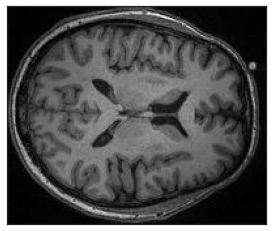

In [90]:
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import random

dataset = ImageFolder("/Users/taraapple/Downloads/A140")
sample_idx = random.randint(0, len(dataset) - 1)

# plotting the sample image
ax = plt.subplot(1,1,1)
plt.setp(ax, xticklabels=[])
plt.setp(ax, yticklabels=[])
plt.xticks([])
plt.yticks([])
plt.imshow(dataset[sample_idx][0])
plt.show()

To show the output of the transform, i.e. the corresponding spike-wave tensor, we plot each time-step separately for each feature until the 5th time-step. We also plot the accumulation of spikes over all of the features.

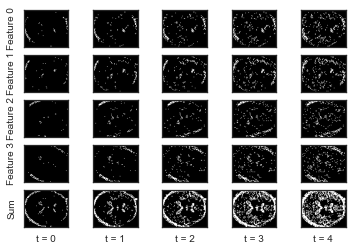

In [91]:
import numpy as np

dataset = ImageFolder("/Users/taraapple/Downloads/A140", transform) # adding transform to the dataset
plt.style.use('seaborn-white')
plt_idx = 0
sw = dataset[sample_idx][0]
for f in range(4):
	for t in range(5):
		plt_idx += 1
		ax = plt.subplot(5, 5, plt_idx)
		plt.setp(ax, xticklabels=[])
		plt.setp(ax, yticklabels=[])
		if t == 0:
			ax.set_ylabel('Feature ' + str(f))
		plt.imshow(sw[t,f].numpy(),cmap='gray')
		if f == 3:
			ax = plt.subplot(5, 5, plt_idx + 5)
			plt.setp(ax, xticklabels=[])
			plt.setp(ax, yticklabels=[])
			if t == 0:
				ax.set_ylabel('Sum')
			ax.set_xlabel('t = ' + str(t))
			plt.imshow(sw[t].sum(dim=0).numpy(),cmap='gray')
plt.show()

To manage data loading, we use `DataLoader` provided by `torch.utils.data`. Here, we shuffle and split the whole dataset into two training (75%) and testing (25%) parts. Then, the corresponding indices will be given to data loaders.

In [92]:
# splitting training and testing sets
indices = list(range(len(dataset)))
random.shuffle(indices)
split_point = int(0.8*len(indices))
train_indices = indices[:split_point]
test_indices = indices[split_point:]
print("Size of the training set:", len(train_indices))
print("Size of the  testing set:", len(test_indices))

Size of the training set: 604
Size of the  testing set: 151


Since the transform from image to spike-wave tensor is time-consuming and static, we use `SpykeTorch.utils.CacheDataset` to cache spike-wave tensors for each image. `CacheDataset` is a wrapper that can work with other PyTorch's `dataset` objects as well.

In [93]:
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler

dataset = utils.CacheDataset(dataset)
train_loader = DataLoader(dataset, sampler=SubsetRandomSampler(train_indices))
test_loader = DataLoader(dataset, sampler=SubsetRandomSampler(test_indices))

## 2. Layers C1 and S2
As mentioned before, C1 is a local pooling and S2 is a trainable convolutional layer. `SpykeTorch.snn` provides appropriate modules for each.

Layer C1 performs local pooling with window-size = 3 and stride = 2.

In [94]:
import SpykeTorch.snn as snn
pool = snn.Pooling(kernel_size = 3, stride = 2)

Now we create a convolutional layer with 20 features and kernel-size equal to the size of the C1's output. Since Gabor filters are of size 3, each 64x64 input image shrinks to 62x62 after S1. Then by applying the pooling, the size of the C1's output will be 30x30.

In [95]:
conv = snn.Convolution(in_channels=4, out_channels=20, kernel_size=30)

In [96]:
stdp = snn.STDP(conv_layer = conv, learning_rate = (0.05, -0.015))

## 4. Reinforcement Learning
In this section, we show how to train and evaluate layer S2 using R-STDP. First, we reset the weights of S2 and assing it a new `SpykeTorch.snn.STDP` object as the anti-STDP part of the R-STDP.

In [97]:
conv.reset_weight()
anti_stdp = snn.STDP(conv_layer = conv, learning_rate = (-0.05, 0.0005))

 We also need a mapping from each S2 feature to a category. Here, we assing the first 10 to "cup" class and the second 10 to "dog" class.

In [98]:
feature2class = [0] * 10 + [1] * 10
print(feature2class)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### 4.1 Training
Again, each spike-wave tensor is passed through C1 and S2 and the only one winner is chosen. Here, the classification or the decision of the network is the category assigned to the winner feature. If the decision is right (wrong), stdp (anti-stdp) will be applied.

In [99]:
print("Starting Reinforcement Learning ...")
for iter in range(100):
	print('\rIteration:', iter, end="")
	for data,targets in train_loader:
		for x,t in zip(data, targets):
			x = pool(x)
			p = conv(x)
			o, p = sf.fire(p, 20, return_thresholded_potentials=True)
			winners = sf.get_k_winners(p, kwta=1, inhibition_radius=0, spikes=o)
			if len(winners) != 0:
				if feature2class[winners[0][0]] == t:
					stdp(x, p, o, winners)
				else:
					anti_stdp(x, p, o, winners)
print()
print("Reinforcement Learning is Done.")

Starting Reinforcement Learning ...
Iteration: 99
Reinforcement Learning is Done.


### 4.2 Reconstructing Features
We use the same procedure as the one in unsupervised learning section.

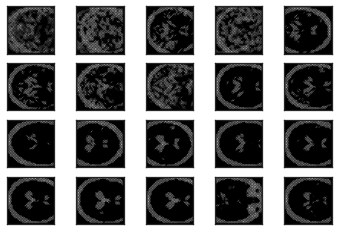

In [100]:
import SpykeTorch.visualization as vis
import torch
feature = torch.stack([k() for k in kernels])
cstride = (1,1)
# C1 Features #
feature,cstride = vis.get_deep_feature(feature, cstride, (3, 3), (2, 2))
# S2 Features #
feature,cstride = vis.get_deep_feature(feature, cstride, (30,30), (1,1), conv.weight)

feature_idx = 0
for r in range(4):
    for c in range(5):
        ax = plt.subplot(4, 5, feature_idx+1)
        plt.xticks([])
        plt.yticks([])
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        plt.imshow(feature[feature_idx].numpy(),cmap='gray')
        feature_idx += 1
plt.show()

### 4.3 Evaluation
Since the classification is done totally based on the S2 activities, there is no need for an external classifier. We feed the testing samples to the network and check how many errors it makes.

In [101]:
error = 0
silent = 0
total = 0
for data,targets in test_loader:
	for x,t in zip(data, targets):
		total += 1
		x = pool(x)
		p = conv(x)
		o, p = sf.fire(p, 20, return_thresholded_potentials=True)
		winners = sf.get_k_winners(p, kwta=1, inhibition_radius=0, spikes=o)
		if len(winners) != 0:
			if feature2class[winners[0][0]] != t:
				error += 1
		else:
			silent += 1
print("         Error:", error/total)
print("Silent Samples:", silent/total)

         Error: 0.24503311258278146
Silent Samples: 0.0
